In [3]:
!echo $CUDA_VISIBLE_DEVICES

0,1


In [4]:
import torch

In [5]:
# DEVICE = torch.device('cpu')
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [6]:
from tqdm.notebook import tqdm

In [7]:
%run ../datasets/iu_xray.py
%run ../training/report_generation/hierarchical.py
%run ../utils/nlp.py

In [8]:
train_dataset = IUXRayDataset('train')
len(train_dataset)

5923

### Compute dataset stats

In [22]:
from collections import Counter

In [25]:
def get_dataset_stats(dataset):
    word_appearances = dict()

    words_count = []
    sentences_count = []

    for image, report in tqdm(dataset):
        # Save appearances
        for word in report:
            if word not in word_appearances:
                word_appearances[word] = 0
            word_appearances[word] += 1

        # Must end with a dot
        if report[-1] != END_OF_SENTENCE_IDX:
            report.append(END_OF_SENTENCE_IDX)

        # Count words
        n_words = len(report)
        words_count.append(n_words)

        # Count sentences
        n_sentences = report.count(END_OF_SENTENCE_IDX)
        sentences_count.append(n_sentences)

    return word_appearances, words_count, sentences_count

In [26]:
word_appearances, words_count, sentences_count = get_dataset_stats(train_dataset)

{17: 7788,
 378: 77,
 37: 1089,
 4: 27050,
 337: 143,
 362: 32,
 176: 284,
 50: 2718,
 32: 3373,
 52: 3724,
 10: 3398,
 13: 5931,
 27: 564,
 23: 4093,
 46: 1220,
 44: 586,
 14: 2485,
 8: 4642,
 11: 6869,
 299: 55,
 135: 497,
 136: 208,
 5: 10078,
 201: 539,
 16: 6950,
 26: 3651,
 53: 158,
 71: 231,
 127: 526,
 973: 1,
 922: 19,
 19: 476,
 39: 3924,
 555: 9,
 974: 1,
 523: 12,
 524: 48,
 1290: 2,
 30: 593,
 62: 2341,
 878: 5,
 181: 770,
 285: 209,
 283: 79,
 930: 52,
 217: 249,
 661: 35,
 265: 277,
 29: 1260,
 123: 834,
 28: 3850,
 22: 4174,
 219: 127,
 349: 66,
 359: 59,
 395: 61,
 51: 216,
 9: 934,
 49: 241,
 35: 697,
 25: 4005,
 55: 491,
 76: 27,
 77: 35,
 63: 1450,
 78: 7,
 45: 1164,
 165: 404,
 166: 343,
 20: 2767,
 225: 197,
 206: 7,
 43: 1673,
 449: 37,
 158: 171,
 164: 944,
 113: 213,
 718: 20,
 112: 475,
 226: 161,
 131: 354,
 107: 317,
 450: 117,
 139: 871,
 109: 942,
 730: 19,
 568: 39,
 533: 42,
 341: 119,
 258: 174,
 363: 117,
 260: 77,
 284: 388,
 41: 706,
 228: 270,
 292:

In [67]:
import matplotlib.pyplot as plt
import numpy as np

In [65]:
def plot_counter(counter, title):
    x = list(counter.keys())
    y = list(counter.values())
    
    plt.bar(x, y)
    plt.title(title)

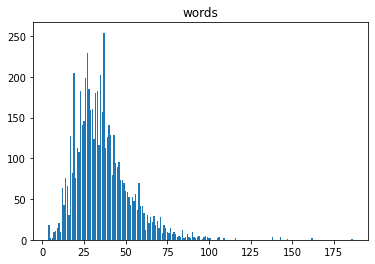

In [66]:
plot_counter(Counter(words_count), 'words')

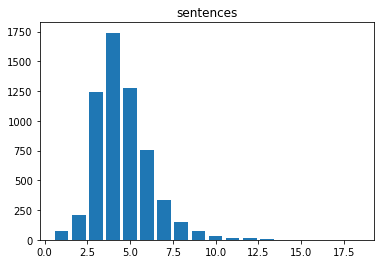

In [70]:
plot_counter(Counter(sentences_count), 'sentences')

In [77]:
counter = Counter(sentences_count)

In [94]:
def get_percentiles(counter):
    items = sorted(counter.items())

    keys, values = zip(*items)

    return list(zip(keys, np.cumsum(values) / total * 100))

In [95]:
get_percentiles(Counter(words_count))

[(4, 0.30390005065000847),
 (5, 0.3376667229444538),
 (6, 0.37143339523889923),
 (7, 0.5402667567111261),
 (8, 0.7259834543305757),
 (9, 0.9792334965389161),
 (10, 1.3169002194833699),
 (11, 1.485733580955597),
 (12, 2.566267094377849),
 (13, 3.2922505487084246),
 (14, 4.575384095897349),
 (15, 5.689684281614047),
 (16, 6.196184366030728),
 (17, 8.340368056728009),
 (18, 9.724801620800271),
 (19, 13.169002194833698),
 (20, 14.452135742022623),
 (21, 16.35995272665879),
 (22, 18.183353030558838),
 (23, 21.27300354550059),
 (24, 23.65355394225899),
 (25, 26.118521019753505),
 (26, 29.461421576903597),
 (27, 33.327705554617594),
 (28, 36.451122741853794),
 (29, 39.135573189262196),
 (30, 41.83690697281783),
 (31, 43.93044065507345),
 (32, 46.96944116157353),
 (33, 50.05909167651528),
 (34, 52.017558669593114),
 (35, 55.4279925713321),
 (36, 58.07867634644606),
 (37, 62.367043727840624),
 (38, 64.25797737632956),
 (39, 66.38527773087962),
 (40, 68.76582812763802),
 (41, 70.94377849062975),

In [96]:
get_percentiles(Counter(sentences_count))

[(1, 1.2324835387472564),
 (2, 4.761100793516799),
 (3, 25.730204288367382),
 (4, 55.10720918453487),
 (5, 76.66722944453824),
 (6, 89.39726489954415),
 (7, 95.03629917271653),
 (8, 97.6194496032416),
 (9, 98.86881647813608),
 (10, 99.42596657099443),
 (11, 99.71298328549722),
 (12, 99.89869998311667),
 (13, 99.96623332770555),
 (17, 99.98311666385278),
 (18, 100.0)]

### Evaluate models in subsets

In [7]:
%run -n train_report_generation.py
%run datasets/__init__.py
%run models/checkpoint/__init__.py
%run training/report_generation/flat.py
%run training/report_generation/hierarchical.py
%run models/report_generation/__init__.py

In [8]:
def eval_in_subset(run_name, compiled_model, debug=True, max_n_words=None, max_n_sentences=None,
                   device='cuda'):
    # Create datasets
    vocab = compiled_model.metadata['vocab']
    train_dataset = IUXRayDataset('train', vocab=vocab)
    val_dataset = IUXRayDataset('val', vocab=vocab)
    test_dataset = IUXRayDataset('test', vocab=vocab)
    
    # Prepare subsets
    subset_kwargs = {
        'max_n_words': max_n_words,
        'max_n_sentences': max_n_sentences,
    }
    
    train_subset = create_report_dataset_subset(train_dataset, **subset_kwargs)
    val_subset = create_report_dataset_subset(val_dataset, **subset_kwargs)
    test_subset = create_report_dataset_subset(test_dataset, **subset_kwargs)
    
    # Decide hierachical
    decoder_name = compiled_model.metadata['decoder_kwargs']['decoder_name']
    hierarchical = is_decoder_hierarchical(decoder_name)
    if hierarchical:
        create_dataloader = create_hierarchical_dataloader
    else:
        create_dataloader = create_flat_dataloader

    # Create dataloaders
    BS = 50
    train_dataloader = create_dataloader(train_subset, batch_size=BS)
    val_dataloader = create_dataloader(val_subset, batch_size=BS)
    test_dataloader = create_dataloader(test_subset, batch_size=BS)
    
    # Create a suffix
    if max_n_words:
        suffix = f'max-words-{max_n_words}'
    elif max_n_sentences:
        suffix = f'max-sentences-{max_n_sentences}'
        
    evaluate_and_save(run_name,
                      compiled_model.model,
                      train_dataloader,
                      val_dataloader,
                      test_dataloader,
                      hierarchical=hierarchical,
                      debug=debug,
                      device=device,
                      suffix=suffix,
                     )

In [13]:
eval_n_words = [
    20 , # --> 15%
    25 , # --> 26%
    27 , # --> 33%
    33 , # --> 50%
#     39 , # --> 66%
#     41 , # --> 70%
    44 , # --> 75%
#     47 , # --> 80%
#     58 , # --> 90%
    # None, # --> 100%
]

In [14]:
eval_n_sentences = [
#     1, # 1.2324835387472564
#     2, # 4.761100793516799
    3, # 25.730204288367382
    4, # 55.10720918453487
    5, # 76.66722944453824
    6, # 89.39726489954415
#     7, # 95.03629917271653
#     8, # 97.6194496032416
#     9, # 98.86881647813608
#     10, # 99.42596657099443
#     11, # 99.71298328549722
#     12, # 99.89869998311667
#     13, # 99.96623332770555
#     17, # 99.98311666385278
#     18, # 100
]

In [15]:
run_names = [
#     '0717_041434_lstm_lr0.0001_densenet-121',
    '0716_211601_lstm-att_lr0.0001_densenet-121', # faltan 33 y 34
#     '0717_015057_h-lstm_lr0.0001_densenet-121',
#     '0716_234501_h-lstm-att_lr0.0001_densenet-121',
]
debug = False

In [16]:
for run_name in run_names:
    compiled_model = load_compiled_model_report_generation(run_name,
                                                           debug=debug,
                                                           multiple_gpu=True,
                                                           device=DEVICE)
    for n_words in tqdm(eval_n_words):
        eval_in_subset(run_name,
                       compiled_model,
                       max_n_words=n_words,
                       max_n_sentences=None,
                       debug=debug,
                       device=DEVICE,
                      )
    for n_sentences in tqdm(eval_n_sentences):
        eval_in_subset(run_name,
                       compiled_model,
                       max_n_words=None,
                       max_n_sentences=n_sentences,
                       debug=debug,
                       device=DEVICE,
                      )

Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-words-33.json
Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-words-44.json



Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-sentences-3.json
Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-sentences-4.json
Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-sentences-5.json
Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-sentences-6.json



### Debug dummy baselines

In [12]:
%run ../training/report_generation/flat.py
%run ../training/report_generation/hierarchical.py

In [9]:
train_dataset = IUXRayDataset('train')
len(train_dataset)

5923

In [10]:
vocab = train_dataset.get_vocab()
val_dataset = IUXRayDataset('val', vocab=vocab)
test_dataset = IUXRayDataset('test', vocab=vocab)

In [13]:
BS = 30

train_dataloader = create_flat_dataloader(train_dataset, batch_size=BS)
val_dataloader = create_flat_dataloader(val_dataset, batch_size=BS)
test_dataloader = create_flat_dataloader(test_dataset, batch_size=BS)

#### Most common words

In [218]:
WORD_APPEARANCES = defaultdict(lambda: 0)
N_WORDS = []
for report in train_dataset.reports:
    report = report['tokens_idxs']
    for word in report:
        WORD_APPEARANCES[word] += 1
    N_WORDS.append(len(report))
len(WORD_APPEARANCES)

1771

In [219]:
WORD_APPEARANCES = sorted(list(WORD_APPEARANCES.items()), key=lambda x: x[1], reverse=True)
WORD_APPEARANCES

[(4, 27050),
 (5, 10078),
 (17, 7788),
 (16, 6950),
 (11, 6869),
 (13, 5931),
 (38, 5167),
 (8, 4642),
 (22, 4174),
 (23, 4093),
 (25, 4005),
 (39, 3924),
 (28, 3850),
 (15, 3731),
 (52, 3724),
 (26, 3651),
 (10, 3398),
 (32, 3373),
 (20, 2767),
 (50, 2718),
 (12, 2550),
 (14, 2485),
 (62, 2341),
 (18, 2013),
 (21, 1760),
 (43, 1673),
 (7, 1586),
 (122, 1523),
 (63, 1450),
 (36, 1382),
 (29, 1260),
 (46, 1220),
 (45, 1164),
 (56, 1117),
 (37, 1089),
 (40, 1063),
 (164, 944),
 (109, 942),
 (116, 935),
 (9, 934),
 (31, 908),
 (125, 908),
 (24, 907),
 (139, 871),
 (123, 834),
 (124, 829),
 (181, 770),
 (138, 760),
 (115, 738),
 (101, 731),
 (154, 711),
 (41, 706),
 (35, 697),
 (80, 669),
 (6, 651),
 (87, 635),
 (54, 627),
 (79, 626),
 (143, 620),
 (48, 620),
 (126, 597),
 (30, 593),
 (44, 586),
 (27, 564),
 (201, 539),
 (127, 526),
 (132, 510),
 (121, 502),
 (135, 497),
 (55, 491),
 (229, 481),
 (19, 476),
 (112, 475),
 (100, 471),
 (61, 429),
 (200, 413),
 (165, 404),
 (89, 394),
 (193, 

#### Most common sentences

In [116]:
%run ../training/report_generation/hierarchical.py

ImportError: cannot import name 'split_sentences_and_pad'

In [118]:
from collections import defaultdict

In [131]:
SENTENCE_APPEARANCES = defaultdict(lambda: 0)
for report in train_dataset.reports:
    report = report['tokens_idxs']
    if report[-1] != END_OF_SENTENCE_IDX:
        report.append(END_OF_SENTENCE_IDX)
        
    report = _split_sentences_and_pad(report)
    for sentence in report:
        sentence = sentence.tolist()
        sentence = np.trim_zeros(sentence, 'b')
        sentence = ' '.join(str(val) for val in sentence)
        
        SENTENCE_APPEARANCES[sentence] += 1
len(SENTENCE_APPEARANCES)

5332

In [121]:
SENTENCE_APPEARANCES = sorted(list(SENTENCE_APPEARANCES.items()), key=lambda x: x[1], reverse=True)
SENTENCE_APPEARANCES

[('5 32 11 50 4', 559),
 ('17 28 4', 434),
 ('32 11 50 4', 370),
 ('52 10 13 4', 290),
 ('5 52 16 13 62 10 4', 275),
 ('52 10 16 13 4', 273),
 ('17 28 39 25 26 4', 260),
 ('5 9 16 164 4', 224),
 ('17 25 26 39 28 4', 205),
 ('15 16 17 25 26 39 28 4', 205),
 ('52 10 12 13 14 4', 184),
 ('52 8 9 13 4', 163),
 ('49 32 11 50 8 51 4', 158),
 ('5 32 11 50 284 4', 158),
 ('13 52 10 4', 154),
 ('17 25 181 39 238 4', 150),
 ('17 25 26 4', 147),
 ('17 25 26 39 28 16 101 4', 143),
 ('15 16 17 28 4', 136),
 ('331 38 17 27 23 20 21 38 28 38 39 25 26 4', 118),
 ('17 46 124 48 4', 116),
 ('5 32 11 354 23 20 36 37 4', 113),
 ('132 143 125 23 5 333 11 35 46 48 4', 112),
 ('15 16 17 28 39 25 26 4', 108),
 ('124 125 11 126 4', 106),
 ('17 20 261 21 38 17 191 25 26 101 4', 106),
 ('5 52 10 8 18 79 80 12 13 14 4', 103),
 ('5 52 10 16 13 4', 98),
 ('6 8 122 123 11 12 13 14 4', 97),
 ('17 46 337 48 121 4', 97),
 ('17 192 193 23 18 19 4', 97),
 ('5 52 8 32 235 22 22 62 5 104 4', 96),
 ('15 11 17 46 124 193 4',

In [238]:
len(SENTENCE_APPEARANCES)

5332

In [239]:
sum(b for _, b in SENTENCE_APPEARANCES[:500])

16692

In [240]:
sum(b for _, b in SENTENCE_APPEARANCES[:100])

10058

In [241]:
sum(b for _, b in SENTENCE_APPEARANCES)

27050

#### Same report

In [122]:
%run ../utils/nlp.py

In [137]:
dummy_report = '''the heart is normal in size . the mediastinum is unremarkable . the lungs are
clear . there is no pneumothorax or pleural effusion . no focal airspace disease .
no pleural effusion or pneumothorax .'''

In [138]:
sentences = split_sentences_and_pad([vocab[word] for word in dummy_report.split()])
sentences

tensor([[  5,  52,  16,  13,  62,  10,   4,   0],
        [  5,   9,  16, 164,   4,   0,   0,   0],
        [  5,  32,  11,  50,   4,   0,   0,   0],
        [ 15,  16,  17,  28,  39,  25,  26,   4],
        [ 17,  20,  36,  37,   4,   0,   0,   0],
        [ 17,  25,  26,  39,  28,   4,   0,   0]])

In [139]:
import numpy as np

In [140]:
for sentence in sentences:
    sentence = np.trim_zeros(sentence.detach().numpy(), 'b')
    sentence = ' '.join(str(word) for word in sentence)
    print(sentence)
    print(SENTENCE_APPEARANCES[sentence])

5 52 16 13 62 10 4
275
5 9 16 164 4
224
5 32 11 50 4
559
15 16 17 28 39 25 26 4
108
17 20 36 37 4
71
17 25 26 39 28 4
205


In [144]:
(559 + 275 + 224 + 108 + 71 + 205) / sum(values)

0.053308687615526804

In [142]:
values = list(SENTENCE_APPEARANCES.values())
values

[19,
 4,
 12,
 67,
 290,
 49,
 2,
 4,
 8,
 2,
 370,
 31,
 15,
 2,
 23,
 1,
 1,
 2,
 1,
 2,
 44,
 2,
 1,
 13,
 2,
 16,
 434,
 4,
 2,
 2,
 163,
 158,
 154,
 2,
 10,
 6,
 2,
 2,
 27,
 19,
 2,
 2,
 40,
 22,
 147,
 559,
 273,
 2,
 2,
 2,
 6,
 21,
 260,
 2,
 35,
 7,
 9,
 2,
 15,
 17,
 7,
 1,
 3,
 3,
 60,
 79,
 2,
 2,
 1,
 2,
 12,
 74,
 2,
 19,
 11,
 5,
 18,
 4,
 2,
 9,
 5,
 48,
 20,
 17,
 2,
 71,
 26,
 2,
 205,
 2,
 9,
 3,
 14,
 2,
 2,
 4,
 8,
 2,
 2,
 19,
 2,
 4,
 1,
 1,
 6,
 4,
 4,
 2,
 2,
 65,
 2,
 8,
 13,
 3,
 2,
 2,
 2,
 47,
 184,
 17,
 2,
 2,
 2,
 19,
 4,
 15,
 3,
 2,
 43,
 2,
 1,
 2,
 6,
 2,
 83,
 2,
 5,
 2,
 18,
 6,
 9,
 4,
 3,
 2,
 2,
 2,
 7,
 27,
 275,
 224,
 19,
 68,
 2,
 56,
 2,
 97,
 8,
 2,
 2,
 8,
 40,
 2,
 4,
 2,
 2,
 2,
 45,
 2,
 6,
 2,
 10,
 6,
 37,
 64,
 4,
 2,
 4,
 3,
 3,
 3,
 3,
 7,
 12,
 4,
 3,
 1,
 2,
 2,
 4,
 12,
 5,
 4,
 63,
 66,
 2,
 2,
 4,
 26,
 2,
 5,
 2,
 4,
 2,
 2,
 4,
 2,
 18,
 2,
 2,
 41,
 16,
 18,
 2,
 2,
 2,
 150,
 22,
 2,
 2,
 51,
 2,
 106,
 10,
 27,
 2,
 2,